<a href="https://colab.research.google.com/github/zeyadmageid/COVID19_Project_CNN/blob/main/COVID_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries and getting access to google drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
import os
#pip install opencv-python
import cv2
import joblib
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
!pip install keras-tuner
import keras_tuner as kt
from matplotlib import pyplot
from keras_tuner import RandomSearch
from keras_tuner.engine import hyperparameters
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
# This will prompt for authorization.
drive.mount('/content/drive')

# Loading Dataset and adding labels to images

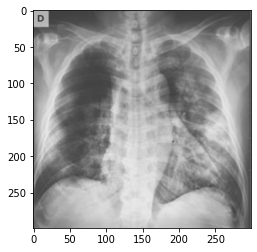

COVID


In [ ]:
directory_train = '/content/drive/MyDrive/covid_prediction_dataset/train'
directory_test = '/content/drive/MyDrive/covid_prediction_dataset/test'
directory_val = '/content/drive/MyDrive/covid_prediction_dataset/val'

categories = ['COVID', 'LungOpacity', 'Normal', 'ViralPneumonia']

for category in categories:
  path = os.path.join(directory_train, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img))
    plt.imshow(img_array)
    plt.show()
    print(category)
    break
  break #here we break out of the loop to print one of the images from the dataset along with its label

In [ ]:
for category in categories:
  print(category)
  print(categories.index(category))
  #listing the categories of the images

COVID
0
LungOpacity
1
Normal
2
ViralPneumonia
3


# Creating Training, Testing and Validation Datasets

In [ ]:
testing_data = []
val_data = []
training_data = []

def create_training_data():
  for category in categories:
    path = os.path.join(directory_train, category)
    class_num = categories.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      training_data.append([img_array, class_num])


def create_testing_data():
  for category in categories:
    path = os.path.join(directory_test, category)
    class_num = categories.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      testing_data.append([img_array, class_num])



def create_val_data():
  for category in categories:
    path = os.path.join(directory_val, category)
    class_num = categories.index(category)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      val_data.append([img_array, class_num])

In [ ]:
create_training_data()
create_testing_data()
create_val_data()

In [ ]:
random.shuffle(training_data)
random.shuffle(testing_data)
random.shuffle(val_data)

#joblib.dump(training_data,'training_dataset')
#joblib.dump(testing_data,'testing_dataset')
#joblib.dump(val_data,'val_dataset')

# Splitting datasets into features to input to the CNN and labels to compute accuracy and loss

In [ ]:
X = []
Y = []
X_test = []
Y_test = []
X_val = []
Y_val = []
for features, label in training_data:
  X.append(features)
  Y.append(label)

for features, label in testing_data:
  X_test.append(features)
  Y_test.append(label)


for features, label in val_data:
  X_val.append(features)
  Y_val.append(label)


X = np.array(X).reshape(-1, 299, 299, 3)
X_test = np.array(X_test).reshape(-1,299,299,3)
X_val = np.array(X_val).reshape(-1,299,299,3)

# Normalizing the data

In [ ]:
x_train = X/255.0
x_test = X_test/255.0
x_val = X_val/255.0
y_train = np.array(Y)
y_test = np.array(Y_test)
y_val = np.array(Y_val)

# Defining the function which builds the model and defining another function to plot model diagnositics during training

In [ ]:
def covid_model(hp):
          covid_model = tf.keras.models.Sequential()
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
          covid_model.add(Conv2D(filters = 32, kernel_size=(hp.Choice('kernel', values = [3,4,5,6]),hp.Choice('kernel', values = [3,4,5,6])) , input_shape = (299,299,3)))
          covid_model.add(Activation('relu'))
          covid_model.add(MaxPool2D(2,2))
          covid_model.add(Conv2D(hp.Int('input_units', min_value = 32, max_value = 256, step = 32), (4,4)))
          covid_model.add(Activation('relu'))
          covid_model.add(MaxPool2D(2,2))


    # The loop convolution
          for i in range(hp.Int('n_layers', 3, 7)):
             covid_model.add(Conv2D(hp.Int('input_units', min_value = 32, max_value = 256, step = 32), (4,4)))
             covid_model.add(Activation('relu'))
             covid_model.add(Dropout(0.2))


    # Flatten the results to feed into a DNN


          covid_model.add(Flatten())
          covid_model.add(Dense(256, activation='relu'))
          covid_model.add(Dropout(0.2))
          covid_model.add(Dense(128, activation='relu'))
          covid_model.add(Dropout(0.2))
          covid_model.add(Dense(32, activation='relu'))
          covid_model.add(Dense(4, activation='softmax'))

          opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

          covid_model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
          return covid_model


def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

# Hyperparameter Tuning using RandomSearch

In [ ]:
tuned_covid_model = RandomSearch(
    covid_model,
    objective = 'val_accuracy',
    #kt.Objective('accuracy',direction='max'),
    max_trials = 92,
    executions_per_trial = 2,
)

#stop_early = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)


tuned_covid_model.search(x = x_train,
             y = y_train,
             epochs = 1,
             batch_size = 16,
             validation_data = (x_val, y_val)
             #callbacks=[stop_early]
             )


#6 kernel 128 input units 3 layers 0.8135451376438141 value was obtained


Trial 93 Complete [00h 02m 23s]
val_accuracy: 0.7081939876079559

Best val_accuracy So Far: 0.8135451376438141
Total elapsed time: 00h 02m 23s
INFO:tensorflow:Oracle triggered exit


# Getting the best model

In [ ]:
tuned_covid_model.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 294, 294, 32)      3488      
                                                                 
 activation (Activation)     (None, 294, 294, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 147, 147, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 144, 144, 128)     65664     
                                                                 
 activation_1 (Activation)   (None, 144, 144, 128)     0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 72, 128)      0         
 2D)                                                    

# Training the best model and testing it

In [ ]:
#6 kernel 128 input units 3 layers 0.8135451376438141 value was obtained

          covid_final_model = tf.keras.models.Sequential()
          covid_final_model.add(Conv2D(32,(6,6) , input_shape = (299,299,3)))
          covid_final_model.add(Activation('relu'))
          covid_final_model.add(MaxPool2D(2,2))
          covid_final_model.add(Conv2D(128, (4,4)))
          covid_final_model.add(Activation('relu'))
          covid_final_model.add(MaxPool2D(2,2))


          covid_final_model.add(Conv2D(128, (4,4)))
          covid_final_model.add(Activation('relu'))
          covid_final_model.add(Dropout(0.2))
          covid_final_model.add(Conv2D(128, (4,4)))
          covid_final_model.add(Activation('relu'))
          covid_final_model.add(Dropout(0.2))
          covid_final_model.add(Conv2D(128, (4,4)))
          covid_final_model.add(Activation('relu'))
          covid_final_model.add(Dropout(0.2))



          covid_final_model.add(Flatten())
          covid_final_model.add(Dense(256, activation='relu'))
          covid_final_model.add(Dropout(0.2))
          covid_final_model.add(Dense(128, activation='relu'))
          covid_final_model.add(Dropout(0.2))
          covid_final_model.add(Dense(32, activation='relu'))
          covid_final_model.add(Dense(4, activation='softmax'))

          opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

          covid_final_model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


Epoch 1/100
175/175 [==============================] - 18s 98ms/step - loss: 0.5391 - accuracy: 0.7988 - val_loss: 0.5037 - val_accuracy: 0.8077
Epoch 2/100
175/175 [==============================] - 17s 95ms/step - loss: 0.4440 - accuracy: 0.8385 - val_loss: 0.3436 - val_accuracy: 0.8629
Epoch 3/100
175/175 [==============================] - 17s 95ms/step - loss: 0.3390 - accuracy: 0.8792 - val_loss: 0.3320 - val_accuracy: 0.8746
Epoch 4/100
175/175 [==============================] - 17s 95ms/step - loss: 0.3074 - accuracy: 0.8835 - val_loss: 0.3538 - val_accuracy: 0.8813
Epoch 5/100
175/175 [==============================] - 17s 95ms/step - loss: 0.2452 - accuracy: 0.9096 - val_loss: 0.3968 - val_accuracy: 0.8545
Epoch 6/100
175/175 [==============================] - 17s 95ms/step - loss: 0.2101 - accuracy: 0.9257 - val_loss: 0.2915 - val_accuracy: 0.8997
Epoch 7/100
175/175 [==============================] - 17s 95ms/step - loss: 0.1822 - accuracy: 0.9299 - val_loss: 0.3006 - val_ac

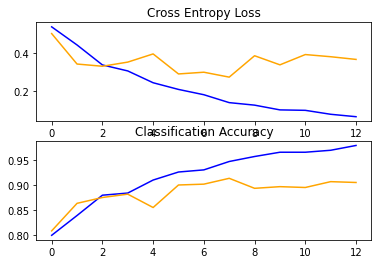

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
from matplotlib import pyplot
summarize_diagnostics(covid_final_model.fit(x_train,y_train, batch_size=16, epochs = 100, validation_data=(x_val,y_val), callbacks = [es]))

In [ ]:
covid_final_model.evaluate(x_test,y_test)

19/19 [==============================] - 1s 40ms/step - loss: 0.2828 - accuracy: 0.9314


[0.28276339173316956, 0.931438148021698]

# Retraining the model with a different batch size of 64 and bigger patience of 10 and then Testing it

Epoch 1/100
44/44 [==============================] - 17s 341ms/step - loss: 0.5064 - accuracy: 0.7956 - val_loss: 0.4176 - val_accuracy: 0.8177
Epoch 2/100
44/44 [==============================] - 12s 265ms/step - loss: 0.4419 - accuracy: 0.8381 - val_loss: 0.3715 - val_accuracy: 0.8495
Epoch 3/100
44/44 [==============================] - 12s 267ms/step - loss: 0.3874 - accuracy: 0.8563 - val_loss: 0.3307 - val_accuracy: 0.8629
Epoch 4/100
44/44 [==============================] - 12s 267ms/step - loss: 0.3468 - accuracy: 0.8713 - val_loss: 0.3313 - val_accuracy: 0.8779
Epoch 5/100
44/44 [==============================] - 12s 268ms/step - loss: 0.3073 - accuracy: 0.8885 - val_loss: 0.2919 - val_accuracy: 0.8896
Epoch 6/100
44/44 [==============================] - 12s 268ms/step - loss: 0.2631 - accuracy: 0.9035 - val_loss: 0.3177 - val_accuracy: 0.8896
Epoch 7/100
44/44 [==============================] - 12s 266ms/step - loss: 0.2490 - accuracy: 0.9056 - val_loss: 0.3024 - val_accuracy:

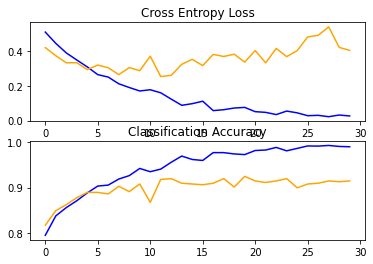

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10)
from matplotlib import pyplot
summarize_diagnostics(covid_final_model.fit(x_train,y_train, batch_size=64, epochs = 100, validation_data=(x_val,y_val), callbacks = [es]))

In [ ]:
covid_final_model.evaluate(x_test,y_test)

19/19 [==============================] - 1s 41ms/step - loss: 0.3289 - accuracy: 0.9331


[0.3288566768169403, 0.9331103563308716]